# Mejora de imágenes en condiciones de baja iluminación

### Introducción

El preprocesamiento de imágenes es una etapa fundamental, especialmente cuando se trabaja con imágenes capturadas en condiciones adversas, como entornos de baja iluminación. Este proyecto tiene como objetivo aplicar y evaluar distintas técnicas de mejora de imágen, buscando optimizar la calidad visual de las imágenes y mejorar su intepretabilidad tanto para observadores humanos como para sistemas automatizados.

Además, el análisis se completa con la evaluación objetiva de métricas como la relacion señal-ruido (SNR), entropía, iluminación media y contraste, permitiendo comparar el impacto de cada técnica. Esto facilita la identificación de las metodologías más efectivas para resolver problemas específicos en visión por computador y proprocesamiento de datos visuales.

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from skimage.measure import shannon_entropy
from skimage import metrics

### Lectura y visualización de la imagen

Definimos una función llamada `read_and_display_image` que permite leer la imagen desde una ruta especifica, convertir el formato predeterminado de OpenCV (BGR) a color (RGB) y mostrar la imagen original.

In [3]:
def read_and_display_image(image_path):
    """
    Read and display the image.
    """
    # Read the image
    img = cv2.imread(image_path)

    if img is None:
        print("Error: No se pudo leer la imagen. Verifica la ruta del archivo")
        return

    # Convertir de BGR a RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title("Imagen Original")
    plt.axis("off")
    plt.show()

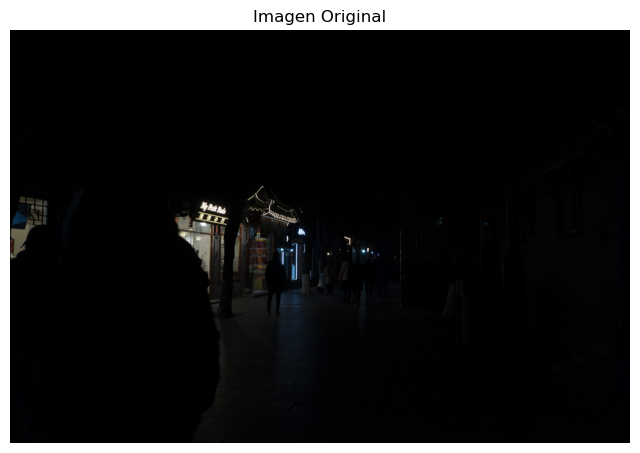

In [5]:
# Ruta de la imagen 
image_path = "image/1234.png"

# Llamar a la funcion 
read_and_display_image(image_path)


### Definición de funciones de preprocesamiento y mejora de imágenes

Se definen funciones esenciales para realizar las diferentes técnicas de preprocesamiento y mejora de imagen con el objetivo de realizar una comparativa de ellas y sus funcionalidades en la mejora de imagenes con baja ilumincación. Así como tambien se incluye una función para realizar métricas objetivas y evaluar la calidad de las transformaciones. 

Las técnicas a utilizar:

1. **Ecualización de histograma** (`histogram_equalization`):
    - Redistribuye los valores de intensidad para mejorar el contraste.
    - Aplica la ecualización a cada canal de color (R, G, B) de la imagen.

2. **CLAHE** (`apply_clahe`)
    - Mejora el contraste de imágenes con iluminación desigual mediante la división en regiones locales.
    - Aplica el método CLAHE (Contrast Limited Adaptive Histogram Equalization) a cada canal de la imagen.

3. **Transformación logaritmica** (`logarithmic_transformation(img)`):
    - Mejora las características de bajo nivel de intensidad expandiendo su rango.

4. **Corrección Gamma** (`gamma_normalization(img, gamma=2.0)`):
    - Utiliza un exponente (`gamma`) para controlar el nivel de ajuste del brillo y el contraste.

5. **Operador aritmético** (`multiplication_operator(img, factor=1.5)`):
    - Se emplea la multiplicación como operador para aumentar el brillo y realzar características especificas.
    - Se aplica escalando los valores de intensidad de la imagen multiplicándolas por un factor.
  
Las métricas para evaluar la calidad de las transformaciones son:

1. **SNR (Signal-to-Noise Ratio):** Relación entre señal y ruido.
2. **Entropía:** Medida de la cantidad de información en la imagen procesada.
3. **Iluminación media:** Promedio de intensidad en la imagen.
4. **Contraste:** Desviación estándar de los valores de intensidad.


In [65]:
def read_image(image_path):
    """
    Leer la imagen y convertirla a RGB.
    """
    img = cv2.imread(image_path)
    if img is None:
        print("Error: No se pudo leer la imagen.")
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def histogram_equalization(img):
    """
    Aplica la ecualización de histograma a cada canal.
    """
    img_eq = np.zeros_like(img)
    for i in range(3): # Para cada canal (R, G, B)
        img_eq[..., i] = cv2.equalizeHist(img[..., i])
    return img_eq

def apply_clahe(img, clip_limit=46.0, tile_grid_size=(8, 8)):
    """
    Aplica CLAHE a cada canal
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    img_clahe = np.zeros_like(img)
    for i in range(3):
        img_clahe[..., i] = clahe.apply(img[..., i])
    return img_clahe

def logarithmic_transformation(img):
    """
    Aplica transformación logaritmica)
    """
    img_float = img / 255.0 # Normalizar entre 0 y 1
    img_log = np.log(1 + img_float) / np.log(1 + np.max(img_float))
    return (img_log * 255).astype(np.uint8)

def gamma_normalization(img_float, gamma=2.0):
    """
    Aplica corrección gamma.
    """
    img_float = img /255.0 # Normalizar entre 0 y 1
    img_gamma = np.power(img_float, gamma) # Aplicar corrección gamma
    return (img_gamma * 255).astype(no.uint8)

def calculate_metrics(original, processed):
    """
    Calcula métricas SNR, entropía, iluminación media y contraste. 
    """
    noise = original - processed
    snr = 10 * no.log10(np.mean(original ** 2) / np.mean(noise ** 2)) if np.mean(noise ** 2) != 0 else np.inf
    entropy = shannon_entropy(processed)
    mean_illumination = np.mean(processed)
    contrast = np.std(processed)
    return snr, entropy, mean_illumination, contrast

def multiplication_operator(img, factor=1.5):
    """
    Aplica operador de multiplicación
    """
    img_float = img / 255.0 # Normalizar entre 0 y 1
    img_mult = np.clip(img_float * factor, 0, 1) # Escalar y limitar entre 0 y 1
    return (img_mult * 255).astype(np.uint8)

### Definición de funciones de visualización y análisis de métricas

Se incluyen funciones para visualizar los resultados de las transformaciones aplicadas y analizar las métricas de calidad para evaluar cada técnica. Permitirán:

- Comparar visualmente la imagen original con las procesadas.
- Graficar métricas clave para evaluar objetivamente el desempeño de cada técnica.
- Mostrar los resultados en una tabla organizada para facilitar el análisis.


In [54]:
def plot_images(original, results, titles):
    """
    Visualizar imágenes originales y procesadas
    """
    plt.figure(figsize=(15, 10))
    images = [original] + results
    for i, img in enumerate(images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_metrics(metrics, titles):
    """
    Visualizar metricas en gráficos de barras por tipo de métrica.
    """
    metrics = np.array(metrics)
    metric_names = ["SNR", "Entropía", "Iluminación Media", "Contraste"]
    x = np.arange(len(titles) - 1) # Índices para las técnicas

    plt.figure(figsize=(18, 12))
    for i in range(metrics.shape[1]):
        plt.subplot(2, 2, i + 1)
        plt.bar(x, metrics[:, i], color='skyblue', alpha=0.7)
        plt.xticks(x, titles[1:], rotation=45)
        plt.title(metric_names[i])
        plt.xlabel("Técnica")
        plt.ylabel("Valor")
        plt.tight_layout()
    plt.show()

def display_metrics_table(metrics, titles):
    """
    Generar y mostrar una tabla con las métricas calculadas.
    """
    metrics_names = ["SNR", "Entropía", "Iluminación Media", "Contraste"]
    techniques = titles[1:] # Exluye el título de la imagen original
    metrics_df = pd.DataFrame(metrics, columns=metrics_names, index=techniques)
    print(metrics_df)
    return metrics_df

### Procesamiento de imagen y análisis de resultados

Se procesa la imagen original con baja iluminación aplicando las técnicas de mejora mencionadas anteriormente. Además, se calculan métricas de calidad como la SNR, Entropía, iluminación media y contraste para evaluar el impacto de cada técnica. Los resultados incluirán:

- Visualización de la imagen original y las procesadas.
- Comparación de métricas en gráficos de barras.
- Generación de una tabla con las métricas, exportandola a un archivo CSV para posible futuro análisis.


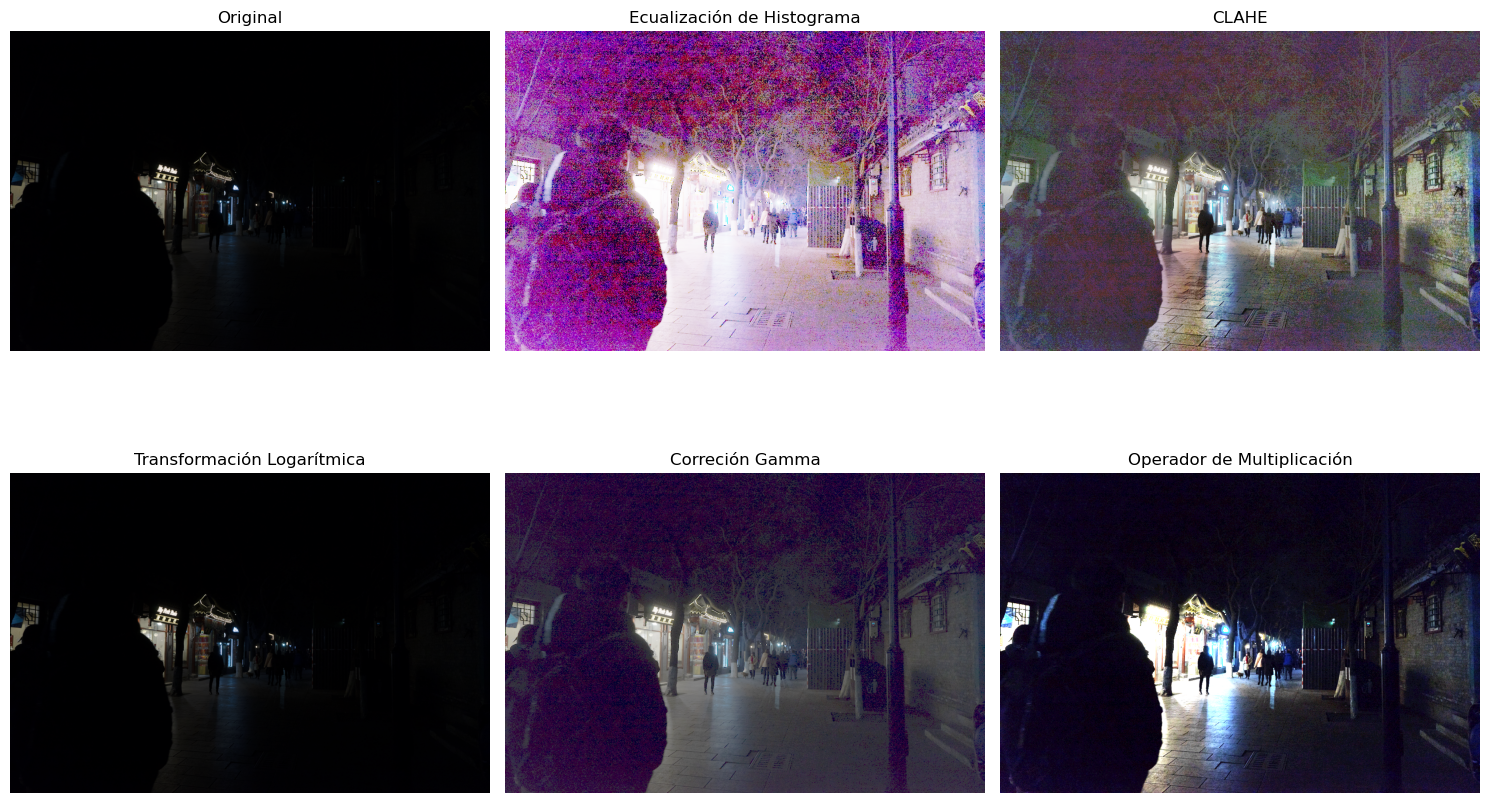

                                 SNR  Entropía  Iluminación Media  Contraste
Ecualización de Histograma -6.090158  3.899666         140.374908  77.974811
CLAHE                      -8.355781  6.511860          87.055119  41.793565
Transformación Logarítmica  4.355087  3.000416           5.063315  16.525340
Correción Gamma            -9.175626  2.990752          52.380574  33.381672
Operador de Multiplicación -9.636974  2.747784          39.166641  58.443469


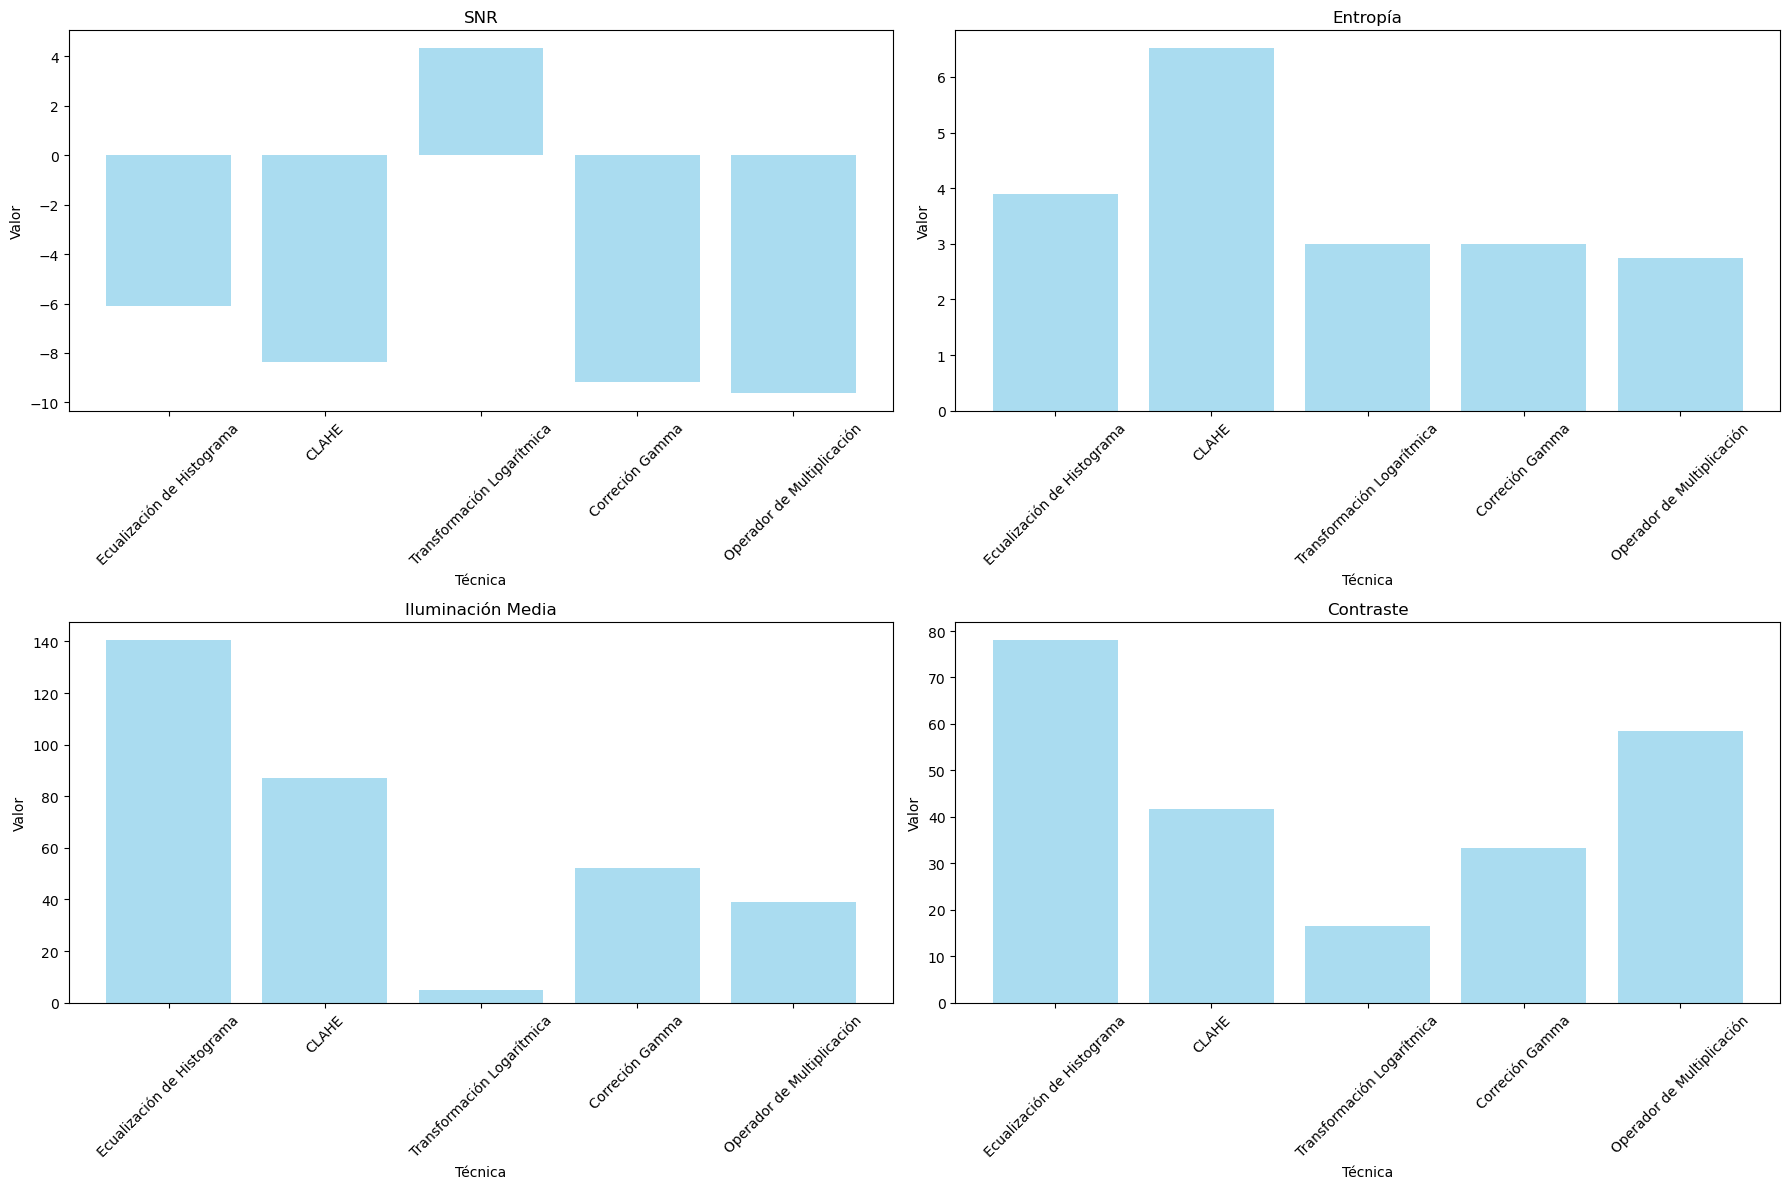

In [68]:
image_path = "image/1234.png" # Cambiar a la ruta de la imagen a procesar

# Leer la imagen 
img = read_image(image_path)

# Calcular métricas
if img is not None:
    img_8bit = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img
    img_hist_eq = histogram_equalization(img_8bit)
    img_clahe = apply_clahe(img_8bit)
    img_log = logarithmic_transformation(img_8bit)
    img_gamma = gamma_normalization(img_8bit, gamma=0.30)
    img_mult = multiplication_operator(img_8bit, factor=14.5)
    results = [img_hist_eq, img_clahe, img_log, img_gamma, img_mult]
    metrics = [calculate_metrics(img_8bit, res) for res in results]

    # Mostrar las imágenes procesadas
    titles = [
        "Original",
        "Ecualización de Histograma",
        "CLAHE",
        "Transformación Logarítmica",
        "Correción Gamma",
        "Operador de Multiplicación",
    ]
    plot_images(img, results, titles)

    # Mostrar las métricas en una tabla
    metrics_df = display_metrics_table(metrics, titles)

    # Guardar la tabla en un archivo CSV
    metrics_df.to_csv("metrics_table_with_multiplication.csv")

    # Visualizar métricas en gráficos de barras
    plot_metrics(metrics, titles)


### Conclusiones

Tras aplicar las diferentes técnicas de mejora en una imagen de baja ilumicación, se observan las siguientes conclusiones:

1. **Ecualizacion de Histograma:**
    - Visualmente, mejora el brillo general, pero introduce ruido significativo.
    - Métricas:
        - **SNR** negativo -6.090158, indicando un incremento del ruido.
        - Alta **iluminación media** y **contraste**, pero con pñerdidad de alidad visual debido al ruido.

2. **CLAHE:**
   - Proporciona un equilibrio visual mejorado, con menos ruido comparado con la ecualización.
   - Métricas:
        - Consta de la **entropía más alta** (6.51), indicando un aumento en la cantidad de información visual.
        - Buen compromiso entre brillo (87.05) y contraste (41.79).

3. **Transformación Logarítmica:**
    - Visualmente, se observar resultados sutiles, con mejoras ligeras en áreas oscuras.
    - Métricas:
        - **SNR positivo** (4.35), lo que refleja un buen manejo del ruido.
        - Baja **iluminación media** (5.06) y contraste (16.52), lo que limita su impacto visual.

4. **Corrección Gamma:**
    - Ajusta el brillo considerablemente, pero los resultados visuales siguen siendo oscuros.
    - Métricas:
        - **Entropía** y **SNR** bajos, con constraste moderado.
    - Es adecuada para ajustes sutiles, pero no en escenas de baja iluminación.

5. **Operador Multiplicación:**
    - Mejora el brillo en áreas clave pero genera un resultado más contrastado y con posible pérdida de detalle en zonas oscuras.
    - Métricas:
        - **Contraste elevado** (58.44) con una **entropía limitada** (2.747784), lo que refleja un aumento en los bordes pero menor cantidad de información en general.
     
### Evaluación general:
- **CLAHE** ofrece el mejor equilibrio entre la calidad visual y las métricas evaluadas, siendo adecuada para mejorar imágenes con iluminación desigual.
- **Transformación Logarítmica** destaca por su manejo del ruido, aunque los resultados visuales son más limitados.
- Técnicas como la **ecualización de histograma** y el **operador de multiplicación** deben eplearse con cuidado debido al ruido y la distorsión que pueden introducir.